In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score
import json
import numba
from functools import partial
from pandas.io.json import json_normalize

from multiprocessing import Pool, cpu_count
from dsb2019.models.tracking import track_experiment, track_submission_info
from dsb2019.data.validation import InstallationFold, cross_validate, quad_kappa
from dsb2019.visualization import session_browser
from dsb2019.data import DATA_DIR
from dsb2019.models import MODELS_DIR
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import hyperopt
import joblib
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK
tqdm.pandas()
pd.options.display.max_rows=999

In [5]:
train = pd.read_csv(DATA_DIR / 'raw/train.csv')
test = pd.read_csv(DATA_DIR / 'raw/test.csv')
train_labels = pd.read_csv(DATA_DIR / 'raw/train_labels.csv')
submission = pd.read_csv(DATA_DIR / 'raw/sample_submission.csv')

In [20]:
games = ['Scrub-A-Dub', 'All Star Sorting', 'Mushroom Sorter (Assessment)',
       'Air Show', 'Crystals Rule', 'Bird Measurer (Assessment)',
       'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time',
       'Cauldron Filler (Assessment)', 'Pan Balance', 'Happy Camel',
       'Cart Balancer (Assessment)', 'Chest Sorter (Assessment)',
       'Leaf Leader']


def unwrap_event_data(df):
    unwrapped = json_normalize(df.event_data.apply(json.loads))
    return pd.concat([unwrapped.reset_index(),df.reset_index()],axis=1)


def process_installations_parallel(process_installations, process_log, df, *dataframes):
    installations = df.installation_id.unique()
    jobs = []
    n_jobs=cpu_count()
    with joblib.Parallel(n_jobs=n_jobs) as workers:
        chunk_size = len(installations) // n_jobs
        for pos, i in enumerate(range(0, len(installations), chunk_size)):
            inst_chunk = installations[i:min(i + chunk_size, len(installations))]
            df_chunk = df[df.installation_id.isin(inst_chunk)].copy()
            dataframes_chunk = [d[d.installation_id.isin(inst_chunk)].copy() for d in dataframes]
            jobs.append(joblib.delayed(process_installations)(process_log, df_chunk, *dataframes_chunk, position=pos))
        result = []
        for result_df in workers(jobs):
            result.append(result_df.reset_index())
    return pd.concat(result).drop("index", axis=1)


def process_installations(process_log, train_labels, train, position=0):
    result = []
    train["timestamp"] = pd.to_datetime(train.timestamp)
    train = train.drop(["event_count"], axis=1)
    train=train.sort_values("timestamp")
    installations = train.groupby("installation_id")
    for i, game_session, title, installation_id, accuracy_group in tqdm(train_labels[["game_session", "title", "installation_id", "accuracy_group"]].itertuples(), 
                                                              total=len(train_labels), position=position):
        player_log = installations.get_group(installation_id).reset_index()
        log_length = player_log[(player_log.game_session==game_session) & (player_log.title==title)].index[0]
        player_log = player_log.iloc[:(log_length + 1)]
        player_log["accuracy_group"] = accuracy_group
        player_log["target_game_session"] = game_session
        features = process_log(player_log)
        features["installation_id"] = installation_id
        features["accuracy_group"] = accuracy_group
        result.append(features)
    return pd.DataFrame(data=result).fillna(-1)


def calculate_ratios(df):
    if len(df)==0:
        return 0, 0, None

    n_correct=df.correct_move.sum()
    n_incorrect=df.wrong_move.sum()
    ratio=n_correct/(n_correct+n_incorrect)
    return n_correct, n_incorrect, ratio


def make_move_stats(assessment, df, title):
    result = []
    result.extend(zip(["n_correct " + title, "n_incorrect " + title, "global_ratio " + title], calculate_ratios(df)))
    return {k: v for k,v in result}


def shrink_session(group):
    group = populate_correct_moves(group)
    correct_moves = group[group.correct_move]
    correct_timestamps = correct_moves.timestamp
    correct_turns = correct_moves.event_count
    time_between_correct_moves = (correct_timestamps - correct_timestamps.shift(1)).dropna() / np.timedelta64(1, "m")
    turns_between_correct_moves = (correct_turns - correct_turns.shift(1)).dropna()
    result = {
    } 
    result["start_time"] = group.timestamp.min()
    result["end_time"] = group.timestamp.max()
    result["duration"] = result["end_time"] - result["start_time"]
    result["correct_move"] = group.correct_move.sum()
    result["wrong_move"] = group.wrong_move.sum()
    result["title"] = group.title.iloc[0]
    result["installation_id"] = group.installation_id.iloc[0]
    result["game_session"] = group.game_session.iloc[0]
    return result


def populate_correct_moves(history: pd.DataFrame) -> pd.DataFrame:
    if "correct" in history.columns:
        history["correct_move"] = history.correct == True
        history["wrong_move"] = history.correct == False
    else:
        history["correct_move"]=False
        history["wrong_move"]=False
    return history

    
def make_base_time_features(assessment, history):
    start_end_times = history
    duration_minutes = start_end_times.duration / np.timedelta64(1, "m")
    result = {
        "mean_session_time_minutes": round(duration_minutes.mean(), 0), 
        #"mean_turns_between_correct_moves": history.mean_turns_between_correct_moves.median(),
        #"mean_time_between_correct_moves": history.mean_time_between_correct_moves.mean(),
        #"mean_time_before_first_correct_move": history.time_before_first_correct_move.mean(),
        #"mean_turns_before_first_correct_move": history.turns_before_first_correct_move.median(),
    }
    last_event_time = assessment.timestamp
    first_event_time = start_end_times.start_time.min()
    
    days_active = round((last_event_time - first_event_time) / np.timedelta64(1, "D"), 0) + 1
    result["games_per_day"] = round(history.game_session.nunique() / days_active, 2)
    
    minutes_between_games = ((start_end_times.start_time - start_end_times.start_time.shift(1)).dropna() / np.timedelta64(1, "m")).round(0)
    result["mean_minutes_between_games"] = round(minutes_between_games.mean(), 2)
    return result


def make_game_time_features(assessment, history, title):
    _1day=history[history.start_time>=(assessment.timestamp-pd.Timedelta(1,'D'))]
    _7days=history[history.start_time>=(assessment.timestamp-pd.Timedelta(7,'D'))]
    result = {
        "hours_played": round(history.duration.sum() / np.timedelta64(1, "h"), 0),
        "games_played": history.game_session.nunique(),
    }
    for suffix, df in [("1d", _1day), ("7d", _7days)]:
        n_correct, n_incorrect, ratio=calculate_ratios(df)
        result["n_correct_"+suffix]=n_correct
        result["n_incorrect_"+suffix]=n_incorrect
        result["game_ratio_"+suffix]=ratio
    return result

    
def apply_on_sessions(assessment, history, n_lags, func_list, title):
    result = {}
    empty = history.head(0)
    if n_lags:
        last_sessions = history.game_session.unique()[-n_lags:]
        for i in range(n_lags):
            for get_features in func_list:
                if i < len(last_sessions):
                    lag_features = get_features(assessment, history[history.game_session==last_sessions[i]], title)
                else:
                    lag_features = get_features(assessment, empty, title)
                features = {}
                for k, v in lag_features.items():
                    features["%s %d" % (k, i)] = v
                result.update(features)
    return result


def make_calendar_features(assessment, history):
    ts = assessment.timestamp
    year = ts.year
    month = ts.month
    dayofweek = ts.dayofweek
    time = ts.time()
    return {
        "month": month,
        "dayofweek": dayofweek,
        "hour": time.hour,
    }


def make_base_features(assessment, history):
    return  {
        "title": games.index(assessment.title)
    }

base_stats = [populate_correct_moves]
base_features = [make_base_features, make_calendar_features, make_base_time_features]
game_features = [make_move_stats, make_game_time_features]
lag_features = [make_move_stats]



def get_base_features(assessment, history):
    result = {}
    for f in base_features:
        result.update(f(assessment, history))
    return result


def get_game_features(assessment, stats, game):
    result = {}
    for f in game_features:
        result.update({game + " " + k: v for k, v in f(assessment, stats, game).items()})
    return result


def get_lag_features(assessment, stats, game, n_lags):
    res = {}
    result = apply_on_sessions(assessment, stats, n_lags, lag_features, game)
    for k, v in result.items():
        res[game + " " + k] = v
    return res       


def process_log(df):
    assessment = df.iloc[-1]
    history = df.iloc[:-1]
    history = history[history.type.isin(["Game", "Assessment"])]
    
    if len(history):
        history = unwrap_event_data(history)
    else:
        return {}
    history.sort_values("timestamp", inplace=True)
    
    for f in base_stats:
        history = f(history)
    
    history = json_normalize(history.groupby("game_session").apply(shrink_session))
    history.sort_values("start_time", inplace=True)
    result = {}
    result.update(get_base_features(assessment, history))
    for game in games:
        stats=history[history.title==game]
        result.update(get_game_features(assessment, stats, game))
        result.update(get_lag_features(assessment, stats, game, 2))
    return result

In [21]:
train_features = process_installations_parallel(process_installations, process_log, train_labels, train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [ ]:
if "index" in train_features.columns:
    raise RuntimeError()

In [22]:
train_features.to_csv(DATA_DIR / "interim/train_features_time_features.csv")

In [23]:
with open("../dsb2019/models/game_baseline_params.json", "r") as f:
    game_params=json.load(f)

def lgb_quad_kappa(preds, true):
    true = true.get_label()
    preds = preds.reshape((4, -1)).argmax(axis=0)
    return "quad_kappa", quad_kappa(true, preds), True
    
    
def train_baseline(x_train,y_train, params=None):
    x_train_all, x_val_all,y_train_all,y_val_all = train_test_split(
        x_train,y_train,
        test_size=0.15,
        random_state=2019,
    )
    train_set = lgb.Dataset(x_train_all, y_train_all)
    val_set = lgb.Dataset(x_val_all, y_val_all)
    return lgb.train(params, train_set, num_boost_round=10000, early_stopping_rounds=2000, valid_sets=[train_set, val_set], verbose_eval=100,
                    feval=lgb_quad_kappa)


def make_features_wrapper(train, test):
    def make_features(df):
        return df.drop(["installation_id", "accuracy_group"], axis=1), df.accuracy_group.values
    
    return make_features(train), make_features(test) 


def make_predictions(model,x_test_all,y_test):
    pred=model.predict(x_test_all).argmax(axis=1)
    return pred,y_test

In [24]:
train_baseline_params=partial(train_baseline,params=game_params)
predictions = cross_validate(train_features, train_features.accuracy_group, make_features_wrapper, train_baseline_params, make_predictions)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	training's multi_logloss: 1.08236	training's quad_kappa: 0.266631	valid_1's multi_logloss: 1.14278	valid_1's quad_kappa: 0.215397
[200]	training's multi_logloss: 1.00433	training's quad_kappa: 0.464994	valid_1's multi_logloss: 1.09393	valid_1's quad_kappa: 0.419408
[300]	training's multi_logloss: 0.951726	training's quad_kappa: 0.521547	valid_1's multi_logloss: 1.06747	valid_1's quad_kappa: 0.457769
[400]	training's multi_logloss: 0.912075	training's quad_kappa: 0.554559	valid_1's multi_logloss: 1.0524	valid_1's quad_kappa: 0.475705
[500]	training's multi_logloss: 0.879694	training's quad_kappa: 0.578583	valid_1's multi_logloss: 1.04276	valid_1's quad_kappa: 0.492362
[600]	training's multi_logloss: 0.85216	training's quad_kappa: 0.592579	valid_1's multi_logloss: 1.03677	valid_1's quad_kappa: 0.502244
[700]	training's multi_logloss: 0.828546	training's quad_kappa: 0.607248	valid_1's multi_logloss: 1.03337	valid_1's qua

In [27]:
mean_score, cv_scores = np.mean([quad_kappa(true, pred) for pred, true in predictions]), [quad_kappa(true, pred) for pred, true in predictions]

In [28]:
mean_score, cv_scores

(0.5091312722509007,
 [0.53695404946506,
  0.5242692903114117,
  0.5082992396170676,
  0.4890864025859084,
  0.48704737927505637])

In [15]:
(0.504415900635456,
 [0.5308435853458475,
  0.520947273474178,
  0.5038941378338113,
  0.48667353180548045,
  0.4797209747179626])

(0.504415900635456,
 [0.5308435853458475,
  0.520947273474178,
  0.5038941378338113,
  0.48667353180548045,
  0.4797209747179626])

In [29]:
baseline_model=train_baseline(train_features.drop(["installation_id", "accuracy_group"], axis=1), train_features.accuracy_group.values, 
               params=game_params)

Training until validation scores don't improve for 2000 rounds
[100]	training's multi_logloss: 1.09002	training's quad_kappa: 0.239997	valid_1's multi_logloss: 1.13246	valid_1's quad_kappa: 0.209277
[200]	training's multi_logloss: 1.01459	training's quad_kappa: 0.469148	valid_1's multi_logloss: 1.08121	valid_1's quad_kappa: 0.421116
[300]	training's multi_logloss: 0.964554	training's quad_kappa: 0.520158	valid_1's multi_logloss: 1.05264	valid_1's quad_kappa: 0.468097
[400]	training's multi_logloss: 0.927357	training's quad_kappa: 0.550625	valid_1's multi_logloss: 1.03554	valid_1's quad_kappa: 0.480354
[500]	training's multi_logloss: 0.898431	training's quad_kappa: 0.567606	valid_1's multi_logloss: 1.02586	valid_1's quad_kappa: 0.491416
[600]	training's multi_logloss: 0.873928	training's quad_kappa: 0.579624	valid_1's multi_logloss: 1.01946	valid_1's quad_kappa: 0.496214
[700]	training's multi_logloss: 0.852982	training's quad_kappa: 0.587994	valid_1's multi_logloss: 1.01525	valid_1's q

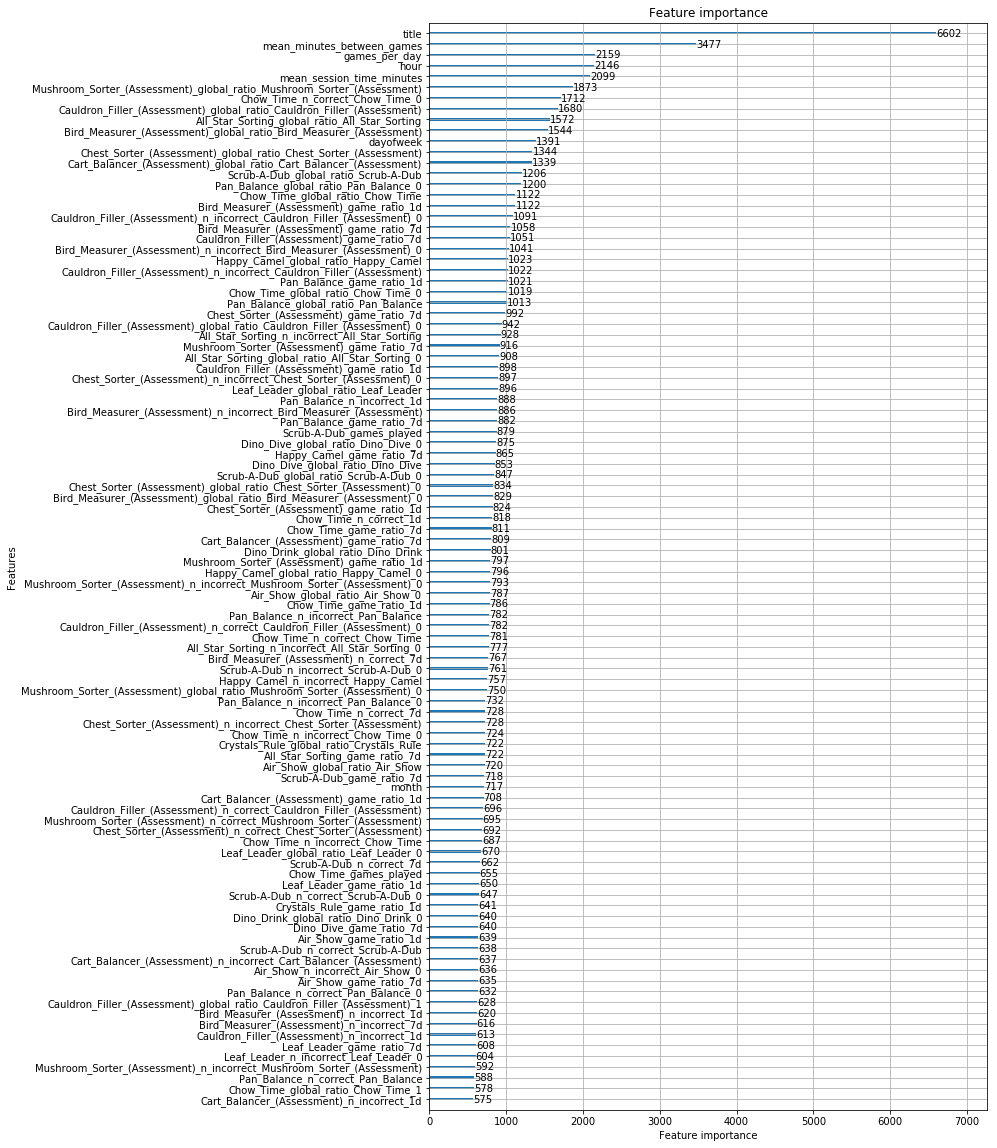

In [30]:
lgb.plot_importance(baseline_model, figsize=(10,20), max_num_features=100)

In [34]:
baseline_model.save_model(str(MODELS_DIR / "time_baseline.lgb"))

In [35]:
mean_score, cv_scores = (0.504415900635456,
 [0.5308435853458475,
  0.520947273474178,
  0.5038941378338113,
  0.48667353180548045,
  0.4797209747179626])
name = "Game baseline"
notebook_path="notebooks/Game baseline.ipynb"
submission_path="notebooks/submissions/Game baseline submission.ipynb"
track_experiment(name, mean_score, cv_scores, notebook_path)
track_submission_info(name, submission_path, 0.445)

,name,time,mean_score,cv_scores,notebook_path,submission_path,submission_score
0,Game baseline,2019-11-04 02:46:37.991522+04:00,0.504416,"[0.5308435853458475, 0.520947273474178, 0.5038941378338113, 0.48667353180548045, 0.4797209747179626]",notebooks/Game baseline.ipynb,notebooks/submissions/Game baseline submission.ipynb,0.445
1,Time + calendar features as is,2019-11-04 02:46:13.502097+04:00,0.509131,"[0.53695404946506, 0.5242692903114117, 0.5082992396170676, 0.4890864025859084, 0.48704737927505637]",Time features.ipynb,NaN,NaN


In [36]:
pd.options.display.max_colwidth = 999
track_experiment("Time + calendar features as is", 0.5091312722509007,
 [0.53695404946506,
  0.5242692903114117,
  0.5082992396170676,
  0.4890864025859084,
  0.48704737927505637], "Time features.ipynb")

,name,time,mean_score,cv_scores,notebook_path,submission_path,submission_score
0,Game baseline,2019-11-04 02:46:37.991522+04:00,0.504416,"[0.5308435853458475, 0.520947273474178, 0.5038941378338113, 0.48667353180548045, 0.4797209747179626]",notebooks/Game baseline.ipynb,notebooks/submissions/Game baseline submission.ipynb,0.445
1,Time + calendar features as is,2019-11-04 02:46:40.201648+04:00,0.509131,"[0.53695404946506, 0.5242692903114117, 0.5082992396170676, 0.4890864025859084, 0.48704737927505637]",Time features.ipynb,NaN,NaN
